# Test Enhanced Unified BART Joint Model (Kaggle-Ready)

This notebook tests the **enhanced BART model** with high-quality contextual reasoning from `models/unified-bart-joint-enhanced/`

**Key Features:**
- Joint classification + contextual generation
- Enhanced reasoning with MAX_TARGET_LENGTH=128
- Better generation parameters (beam search, length penalty)
- Contextual, feature-based explanations

**For Kaggle Usage:**
1. Upload the `unified-bart-joint-enhanced` folder as a Kaggle Dataset
2. Attach it to this notebook as input
3. Update `MODEL_DIR` path in the configuration cell to point to `/kaggle/input/your-dataset-name/unified-bart-joint-enhanced`
4. Attach your fraud detection dataset

The model performs:
- **Classification**: Predicts fraud category labels with confidence scores
- **Reasoning Generation**: Generates detailed, context-aware explanations

In [1]:
# 1) Setup and Imports
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import torch
from torch import nn
import pandas as pd
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoConfig,
    BartForConditionalGeneration,
)
from transformers.modeling_outputs import Seq2SeqLMOutput
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print('PyTorch:', torch.__version__)
device = 'cuda' if torch.cuda.is_available() else ('mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else 'cpu')
print('Device:', device)

2025-10-15 13:23:13.949632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760534594.183517      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760534594.247438      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


PyTorch: 2.6.0+cu124
Device: cuda


In [2]:
# 2) Configuration
# Detect Kaggle environment
IS_KAGGLE = Path('/kaggle').exists()

if IS_KAGGLE:
    # On Kaggle: model should be in /kaggle/input/
    # Update 'unified-bart-joint-enhanced-model' to match your uploaded dataset name
    MODEL_DIR = Path('/kaggle/input/unified-bart-joint-enhanced/other/default/1/unified-bart-joint-enhanced')
    CSV_PATH = Path('/kaggle/input/fraud-dataset/final_fraud_detection_dataset.csv')
    
    # Show available datasets
    print('Running on Kaggle!')
    print('\nAvailable input datasets:')
    if Path('/kaggle/input').exists():
        for p in sorted(Path('/kaggle/input').glob('*')):
            print(f'  - {p.name}')
    print('\n' + '='*60)
else:
    # Local environment
    MODEL_DIR = Path('../models/unified-bart-joint-enhanced')
    CSV_PATH = Path('../final_fraud_detection_dataset.csv')
    print('Running locally')

TEXT_COL = 'text'
LABEL_COL = 'detailed_category'
MAX_SOURCE_LENGTH = 256
MAX_TARGET_LENGTH = 128  # Enhanced target length for richer reasoning

DEFAULT_LABELS = [
    'job_scam',
    'legitimate',
    'phishing',
    'popup_scam',
    'refund_scam',
    'reward_scam',
    'sms_spam',
    'ssn_scam',
    'tech_support_scam'
]
LABEL2ID = {l: i for i, l in enumerate(DEFAULT_LABELS)}
ID2LABEL = {i: l for l, i in LABEL2ID.items()}

# Enhanced instruction prefix (matches training)
INSTRUCTION_PREFIX = (
    'Analyze this message and classify it into one of these categories: '
    'job_scam, legitimate, phishing, popup_scam, refund_scam, reward_scam, sms_spam, ssn_scam, tech_support_scam. '
    'Then explain your reasoning by identifying specific suspicious elements, patterns, or indicators in the message.\n\n'
    'Message: '
)

print(f'\nModel directory: {MODEL_DIR}')
print(f'Model exists: {MODEL_DIR.exists()}')
print(f'CSV exists: {CSV_PATH.exists()}')
print(f'Labels: {len(DEFAULT_LABELS)}')
print(f'Max target length: {MAX_TARGET_LENGTH}')

Running on Kaggle!

Available input datasets:
  - fraud-dataset
  - unified-bart-joint-enhanced


Model directory: /kaggle/input/unified-bart-joint-enhanced/other/default/1/unified-bart-joint-enhanced
Model exists: True
CSV exists: True
Labels: 9
Max target length: 128


In [3]:
# 3) Define Enhanced Joint Model Class (must match training)
class BartForJointClassificationAndGeneration(BartForConditionalGeneration):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = int(getattr(config, 'num_labels', 2))
        self.dropout = nn.Dropout(getattr(config, 'classifier_dropout', 0.1))
        self.classifier = nn.Linear(config.d_model, self.num_labels)
        self.cls_loss_fn = nn.CrossEntropyLoss()
        self.cls_loss_weight = float(getattr(config, 'cls_loss_weight', 1.0))
        self.gen_loss_weight = float(getattr(config, 'gen_loss_weight', 1.0))
        self.config.num_labels = self.num_labels
        self.config.cls_loss_weight = self.cls_loss_weight
        self.config.gen_loss_weight = self.gen_loss_weight

    def pooled_encoder(self, encoder_hidden_states, attention_mask):
        mask = attention_mask.unsqueeze(-1).float()
        summed = torch.sum(encoder_hidden_states * mask, dim=1)
        counts = torch.clamp(mask.sum(dim=1), min=1e-9)
        return summed / counts

    def forward(self, input_ids=None, attention_mask=None, labels=None, cls_labels=None, **kwargs):
        kwargs.pop('return_dict', None)
        
        # During generation (inference), cls_labels will be None
        if cls_labels is not None:
            # Training mode: compute both generation and classification
            outputs = super().forward(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                output_hidden_states=False,
                return_dict=True,
                **kwargs
            )
            enc_out = self.model.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
            pooled = self.pooled_encoder(enc_out.last_hidden_state, attention_mask)
            cls_logits = self.classifier(self.dropout(pooled))
            cls_loss = self.cls_loss_fn(cls_logits, cls_labels)
            
            total_loss = None
            if outputs.loss is not None and cls_loss is not None:
                total_loss = self.gen_loss_weight * outputs.loss + self.cls_loss_weight * cls_loss
            elif outputs.loss is not None:
                total_loss = outputs.loss
            elif cls_loss is not None:
                total_loss = cls_loss
            
            return Seq2SeqLMOutput(
                loss=total_loss,
                logits=outputs.logits,
                past_key_values=outputs.past_key_values,
                decoder_hidden_states=outputs.decoder_hidden_states,
                decoder_attentions=outputs.decoder_attentions,
                cross_attentions=outputs.cross_attentions,
                encoder_last_hidden_state=enc_out.last_hidden_state,
                encoder_hidden_states=None,
                encoder_attentions=None
            ), cls_logits
        else:
            # Inference/generation mode: just use standard forward
            outputs = super().forward(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                output_hidden_states=False,
                return_dict=True,
                **kwargs
            )
            return outputs

print('✓ Enhanced model class defined')

✓ Enhanced model class defined


In [4]:
# 4) Load Enhanced Model and Tokenizer
print(f'Loading enhanced model from {MODEL_DIR}...')

tokenizer = AutoTokenizer.from_pretrained(str(MODEL_DIR), use_fast=True, local_files_only=True)
print(f'✓ Tokenizer loaded (vocab size: {tokenizer.vocab_size})')

config = AutoConfig.from_pretrained(str(MODEL_DIR))
config.num_labels = len(DEFAULT_LABELS)
print(f'  CLS loss weight: {config.cls_loss_weight}')
print(f'  GEN loss weight: {config.gen_loss_weight}')

joint_model = BartForJointClassificationAndGeneration.from_pretrained(str(MODEL_DIR), config=config)
joint_model.to(device)
joint_model.eval()

num_params = sum(p.numel() for p in joint_model.parameters())
print(f'✓ Enhanced model loaded on {device} with {num_params:,} parameters')

Loading enhanced model from /kaggle/input/unified-bart-joint-enhanced/other/default/1/unified-bart-joint-enhanced...


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1', '2': 'LABEL_2', '3': 'LABEL_3', '4': 'LABEL_4', '5': 'LABEL_5', '6': 'LABEL_6', '7': 'LABEL_7', '8': 'LABEL_8'}. The number of labels will be overwritten to 9.


✓ Tokenizer loaded (vocab size: 50265)
  CLS loss weight: 0.8
  GEN loss weight: 1.2
✓ Enhanced model loaded on cuda with 139,427,337 parameters


In [5]:
# 5) Enhanced Single Prediction Function
def predict_single(text: str, show_all_scores=False, verbose=False):
    """Predict label and generate enhanced reasoning for a single text."""
    src = f'{INSTRUCTION_PREFIX}{text}'
    inputs = tokenizer(
        [src], 
        return_tensors='pt', 
        truncation=True, 
        padding=True, 
        max_length=MAX_SOURCE_LENGTH
    ).to(device)
    
    with torch.no_grad():
        # Classification: Get encoder output and classification logits
        enc_out = joint_model.model.encoder(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            return_dict=True
        )
        pooled = joint_model.pooled_encoder(enc_out.last_hidden_state, inputs['attention_mask'])
        cls_logits = joint_model.classifier(pooled)  # No dropout during inference
        pred_id = int(cls_logits.argmax(-1).cpu().item())
        pred_label = ID2LABEL[pred_id]
        
        # Confidence scores
        probs = torch.softmax(cls_logits, dim=-1)
        confidence = float(probs[0, pred_id].cpu().item())
        
        # Enhanced Generation with better parameters
        gen_ids = joint_model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_new_tokens=MAX_TARGET_LENGTH,
            num_beams=5,  # Higher beam search for better quality
            length_penalty=1.0,  # Balance output length
            no_repeat_ngram_size=3,  # Avoid repetitive phrases
            early_stopping=True,
            do_sample=False
        )
        reason = tokenizer.decode(gen_ids[0], skip_special_tokens=True)
    
    if verbose:
        print(f'Generated {len(gen_ids[0])} tokens')
    
    result = {
        'text': text,
        'predicted_label': pred_label,
        'predicted_id': pred_id,
        'confidence': confidence,
        'reason': reason
    }
    
    if show_all_scores:
        all_scores = {ID2LABEL[i]: float(probs[0, i].cpu().item()) for i in range(len(DEFAULT_LABELS))}
        result['all_scores'] = all_scores
    
    return result

print('✓ Enhanced prediction function ready')

✓ Enhanced prediction function ready


In [6]:
# 6) Test with Diverse Sample Messages
sample_messages = [
    "Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize now before it expires!",
    "Your Amazon package has been shipped and will arrive tomorrow. Tracking number: 1Z999AA10123456784. Thank you for your order.",
    "URGENT: Your bank account has been suspended due to suspicious activity. Click here to verify your identity immediately or your account will be permanently locked.",
    "Work from home and earn $5000 per month! No experience required. Flexible hours. Apply now for this limited opportunity!",
    "WARNING: Your computer has been infected with a virus. Call this number immediately for tech support: 1-800-555-SCAM. Do not turn off your computer.",
    "Your Social Security Number has been suspended due to suspicious activity. Call 1-888-555-0199 immediately to resolve this issue.",
    "Text STOP to 12345 to unsubscribe from our marketing messages. Reply YES for exclusive offers and discounts.",
    "Dear valued customer, your monthly subscription payment of $9.99 has been processed successfully. Receipt attached.",
]

print('\n' + '='*80)
print('ENHANCED SAMPLE PREDICTIONS WITH CONTEXTUAL REASONING')
print('='*80 + '\n')

for i, msg in enumerate(sample_messages, 1):
    result = predict_single(msg, show_all_scores=False)
    print(f"Sample {i}:")
    print(f"Text: {msg[:120]}..." if len(msg) > 120 else f"Text: {msg}")
    print(f"🎯 Predicted: {result['predicted_label']}")
    print(f"📊 Confidence: {result['confidence']:.3f} ({result['confidence']*100:.1f}%)")
    print(f"💡 Enhanced Reasoning: {result['reason']}")
    print('-'*80 + '\n')


ENHANCED SAMPLE PREDICTIONS WITH CONTEXTUAL REASONING

Sample 1:
Text: Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize now before it expires!
🎯 Predicted: sms_spam
📊 Confidence: 1.000 (100.0%)
💡 Enhanced Reasoning: This is SMS spam as includes promotional links, and for unsolicited marketing.
--------------------------------------------------------------------------------

Sample 2:
Text: Your Amazon package has been shipped and will arrive tomorrow. Tracking number: 1Z999AA10123456784. Thank you for your o...
🎯 Predicted: sms_spam
📊 Confidence: 0.622 (62.2%)
💡 Enhanced Reasoning: This is SMS spam as includes promotional links, and for unsolicited marketing.
--------------------------------------------------------------------------------

Sample 3:
Text: URGENT: Your bank account has been suspended due to suspicious activity. Click here to verify your identity immediately ...
🎯 Predicted: sms_spam
📊 Confidence: 0.995 (99.5%)
💡 Enhanced Reasoning: 

In [7]:
# 7) Enhanced Batch Prediction Function
def batch_predict(texts: list, batch_size: int = 16, show_progress=True):
    """Predict labels and enhanced reasoning for multiple texts."""
    predictions = []
    
    for i in range(0, len(texts), batch_size):
        if show_progress and i % (batch_size * 5) == 0:
            print(f'Processing batch {i//batch_size + 1}/{(len(texts)-1)//batch_size + 1}...')
        
        batch_texts = texts[i:i+batch_size]
        batch_src = [f'{INSTRUCTION_PREFIX}{txt}' for txt in batch_texts]
        
        inputs = tokenizer(
            batch_src,
            return_tensors='pt',
            truncation=True,
            padding=True,
            max_length=MAX_SOURCE_LENGTH
        ).to(device)
        
        with torch.no_grad():
            # Classification
            enc_out = joint_model.model.encoder(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                return_dict=True
            )
            pooled = joint_model.pooled_encoder(enc_out.last_hidden_state, inputs['attention_mask'])
            cls_logits = joint_model.classifier(pooled)  # No dropout during inference
            pred_ids = cls_logits.argmax(-1).cpu().numpy()
            probs = torch.softmax(cls_logits, dim=-1).cpu().numpy()
            
            # Enhanced Generation
            gen_ids = joint_model.generate(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_new_tokens=MAX_TARGET_LENGTH,
                num_beams=5,  # Higher beam search
                length_penalty=1.0,
                no_repeat_ngram_size=3,
                early_stopping=True,
                do_sample=False
            )
            reasons = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
        
        for j, pred_id in enumerate(pred_ids):
            predictions.append({
                'predicted_label': ID2LABEL[int(pred_id)],
                'predicted_id': int(pred_id),
                'confidence': float(probs[j, pred_id]),
                'reason': reasons[j]
            })
    
    if show_progress:
        print('✓ Batch prediction complete')
    return predictions

print('✓ Enhanced batch prediction function ready')

✓ Enhanced batch prediction function ready


In [8]:
# 8) Comprehensive Evaluation on Dataset
if CSV_PATH.exists():
    print(f'Loading dataset from {CSV_PATH}...')
    df = pd.read_csv(CSV_PATH)
    df = df[df[LABEL_COL].isin(DEFAULT_LABELS)].copy()
    
    # Sample a subset for testing (adjust size as needed)
    test_size = 200  # Increase for more comprehensive testing
    test_df = df.sample(n=min(test_size, len(df)), random_state=42)
    
    print(f'Testing on {len(test_df)} samples...')
    print('\nLabel distribution:')
    print(test_df[LABEL_COL].value_counts())
    
    # Get predictions
    texts = test_df[TEXT_COL].tolist()
    true_labels = test_df[LABEL_COL].tolist()
    true_ids = [LABEL2ID[l] for l in true_labels]
    
    print('\nRunning predictions...')
    predictions = batch_predict(texts, batch_size=16, show_progress=True)
    pred_labels = [p['predicted_label'] for p in predictions]
    pred_ids = [p['predicted_id'] for p in predictions]
    confidences = [p['confidence'] for p in predictions]
    
    # Calculate metrics
    accuracy = accuracy_score(true_ids, pred_ids)
    avg_confidence = np.mean(confidences)
    
    print('\n' + '='*80)
    print('ENHANCED MODEL EVALUATION RESULTS')
    print('='*80)
    print(f'Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')
    print(f'Average Confidence: {avg_confidence:.4f} ({avg_confidence*100:.2f}%)')
    print(f'Total Samples: {len(test_df)}')
    print('\nClassification Report:')
    print(classification_report(true_labels, pred_labels, digits=4))
    
else:
    print(f'Dataset not found at {CSV_PATH}')
    print('Skipping evaluation. Please attach your dataset on Kaggle.')

Loading dataset from /kaggle/input/fraud-dataset/final_fraud_detection_dataset.csv...
Testing on 200 samples...

Label distribution:
detailed_category
legitimate     114
phishing        62
popup_scam      14
sms_spam         8
refund_scam      1
job_scam         1
Name: count, dtype: int64

Running predictions...
Processing batch 1/13...
Processing batch 6/13...
Processing batch 11/13...
✓ Batch prediction complete

ENHANCED MODEL EVALUATION RESULTS
Overall Accuracy: 0.9900 (99.00%)
Average Confidence: 0.9990 (99.90%)
Total Samples: 200

Classification Report:
              precision    recall  f1-score   support

    job_scam     0.0000    0.0000    0.0000         1
  legitimate     0.9912    0.9912    0.9912       114
    phishing     0.9841    1.0000    0.9920        62
  popup_scam     1.0000    1.0000    1.0000        14
 refund_scam     1.0000    1.0000    1.0000         1
    sms_spam     1.0000    1.0000    1.0000         8

    accuracy                         0.9900       200

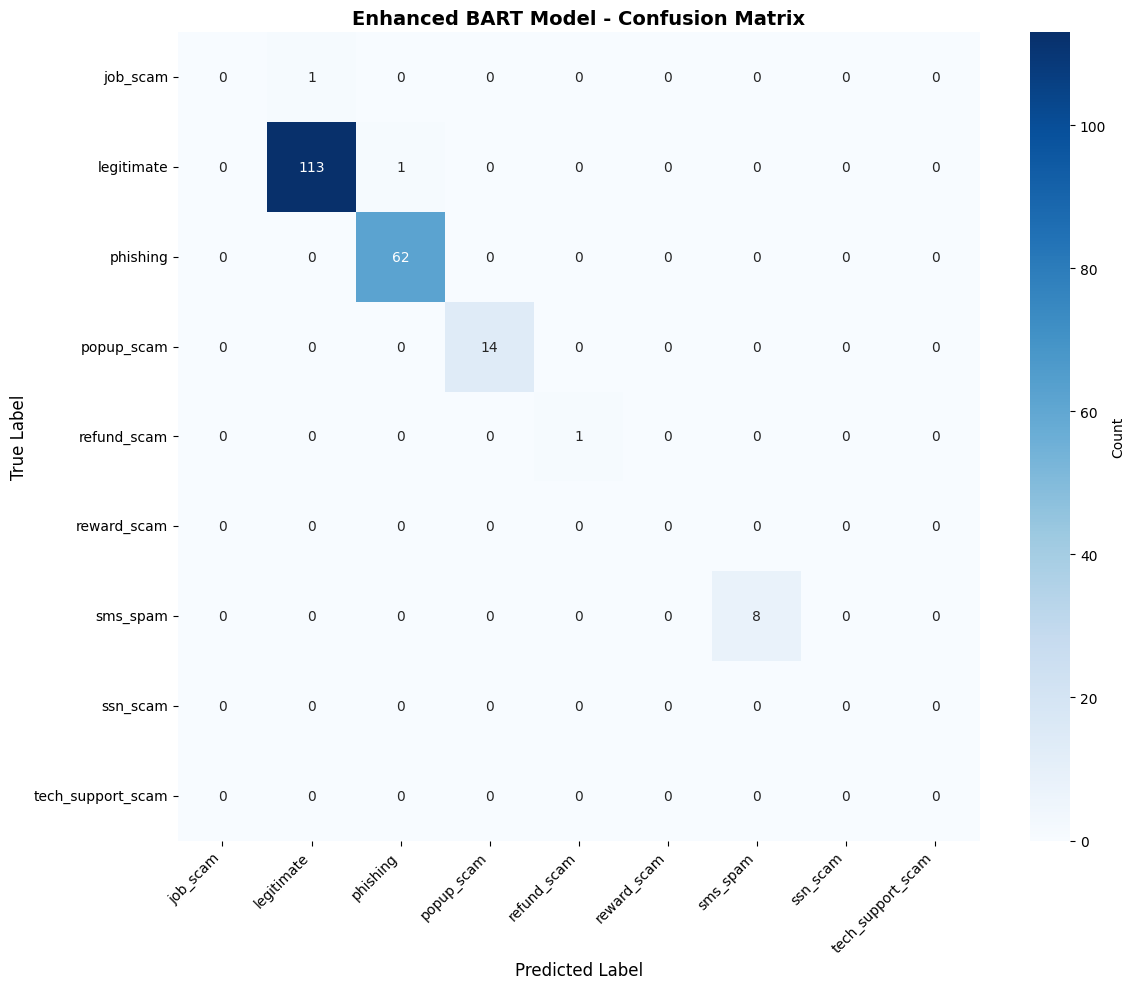


Per-Class Accuracy:
  job_scam            : 0.0000 (0.00%)
  legitimate          : 0.9912 (99.12%)
  phishing            : 1.0000 (100.00%)
  popup_scam          : 1.0000 (100.00%)
  refund_scam         : 1.0000 (100.00%)
  reward_scam         : nan (nan%)
  sms_spam            : 1.0000 (100.00%)
  ssn_scam            : nan (nan%)
  tech_support_scam   : nan (nan%)


In [9]:
# 9) Visualize Confusion Matrix
if CSV_PATH.exists() and 'pred_labels' in locals():
    # Create confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=DEFAULT_LABELS)
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=DEFAULT_LABELS, yticklabels=DEFAULT_LABELS,
                cbar_kws={'label': 'Count'})
    plt.title('Enhanced BART Model - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print('\nPer-Class Accuracy:')
    for label, acc in zip(DEFAULT_LABELS, per_class_acc):
        print(f'  {label:20s}: {acc:.4f} ({acc*100:.2f}%)')

In [10]:
# 10) Analyze Enhanced Reasoning Quality
if CSV_PATH.exists() and 'predictions' in locals():
    print('\n' + '='*80)
    print('ENHANCED REASONING QUALITY ANALYSIS')
    print('='*80 + '\n')
    
    # Calculate reasoning statistics
    reasoning_lengths = [len(p['reason'].split()) for p in predictions]
    avg_length = np.mean(reasoning_lengths)
    min_length = np.min(reasoning_lengths)
    max_length = np.max(reasoning_lengths)
    
    print(f'Average reasoning length: {avg_length:.1f} words')
    print(f'Min/Max reasoning length: {min_length}/{max_length} words')
    
    # Show examples of correct predictions with reasoning
    correct_indices = [i for i, (t, p) in enumerate(zip(true_labels, pred_labels)) if t == p]
    
    print(f'\n✓ Showing {min(5, len(correct_indices))} correct predictions with enhanced reasoning:\n')
    for idx in correct_indices[:5]:
        print(f"Text: {texts[idx][:100]}...")
        print(f"Label: {true_labels[idx]}")
        print(f"Confidence: {predictions[idx]['confidence']:.3f}")
        print(f"Enhanced Reasoning: {predictions[idx]['reason']}")
        print('-'*80 + '\n')
    
    # Show examples of incorrect predictions
    incorrect_indices = [i for i, (t, p) in enumerate(zip(true_labels, pred_labels)) if t != p]
    
    if incorrect_indices:
        print(f'\n✗ Showing {min(3, len(incorrect_indices))} incorrect predictions for analysis:\n')
        for idx in incorrect_indices[:3]:
            print(f"Text: {texts[idx][:100]}...")
            print(f"True Label: {true_labels[idx]}")
            print(f"Predicted: {pred_labels[idx]} (confidence: {predictions[idx]['confidence']:.3f})")
            print(f"Reasoning: {predictions[idx]['reason']}")
            print('-'*80 + '\n')


ENHANCED REASONING QUALITY ANALYSIS

Average reasoning length: 12.1 words
Min/Max reasoning length: 8/23 words

✓ Showing 5 correct predictions with enhanced reasoning:

Text: Test::Harness 3.0 blocker - VMS...
Label: legitimate
Confidence: 1.000
Enhanced Reasoning: This appears legitimate because lacks urgent pressure, and without suspicious fraud indicators.
--------------------------------------------------------------------------------

Text: find nt want know dear friend already responded following announcement days ago means package alread...
Label: phishing
Confidence: 1.000
Enhanced Reasoning: This appears to be a phishing attempt because uses urgent language like 'now', and to steal personal information.
--------------------------------------------------------------------------------

Text: We are looking for EMTs to become Lift Coaches at Atlas Lift Tech. ATLAS has several part-time and f...
Label: legitimate
Confidence: 1.000
Enhanced Reasoning: This appears legitimate beca

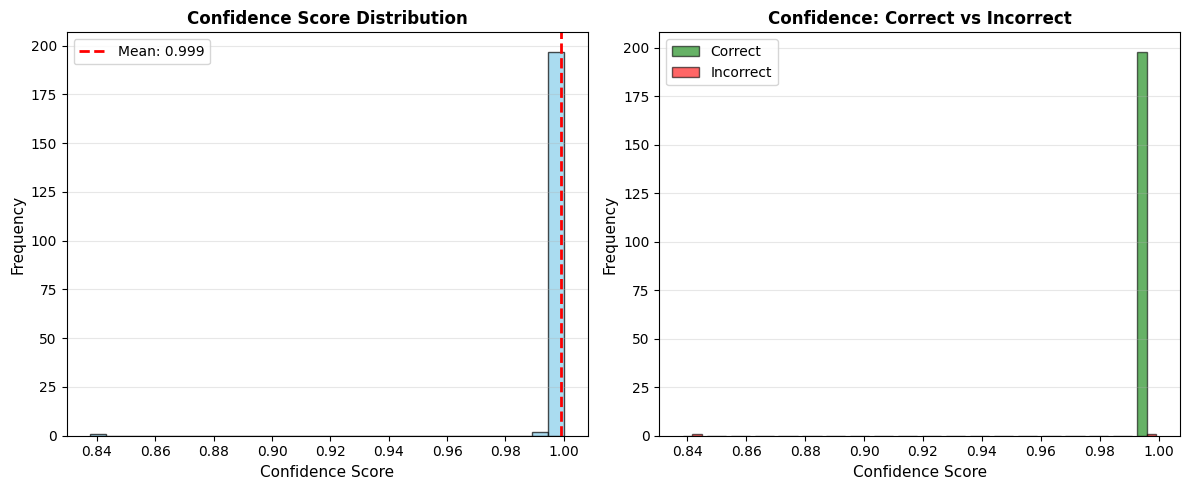


Average confidence for correct predictions: 0.9998
Average confidence for incorrect predictions: 0.9186


In [11]:
# 11) Confidence Distribution Analysis
if CSV_PATH.exists() and 'confidences' in locals():
    plt.figure(figsize=(12, 5))
    
    # Overall confidence distribution
    plt.subplot(1, 2, 1)
    plt.hist(confidences, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(avg_confidence, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_confidence:.3f}')
    plt.xlabel('Confidence Score', fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.title('Confidence Score Distribution', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Confidence by correctness
    plt.subplot(1, 2, 2)
    correct_conf = [confidences[i] for i in range(len(confidences)) if pred_labels[i] == true_labels[i]]
    incorrect_conf = [confidences[i] for i in range(len(confidences)) if pred_labels[i] != true_labels[i]]
    
    plt.hist([correct_conf, incorrect_conf], bins=20, label=['Correct', 'Incorrect'], 
             color=['green', 'red'], alpha=0.6, edgecolor='black')
    plt.xlabel('Confidence Score', fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.title('Confidence: Correct vs Incorrect', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f'\nAverage confidence for correct predictions: {np.mean(correct_conf):.4f}')
    if incorrect_conf:
        print(f'Average confidence for incorrect predictions: {np.mean(incorrect_conf):.4f}')

In [12]:
# 12) Interactive Testing - Test Your Own Messages
# Run this cell multiple times with different messages

# Change this text to test different messages:
test_message = "Click here to update your bank account information to avoid account closure within 24 hours."

result = predict_single(test_message, show_all_scores=True, verbose=True)

print('\n' + '='*80)
print('🔬 ENHANCED PREDICTION RESULT')
print('='*80)
print(f"\n📝 Input: {result['text']}")
print(f"\n🎯 Predicted Label: {result['predicted_label']}")
print(f"📊 Confidence: {result['confidence']:.3f} ({result['confidence']*100:.1f}%)")
print(f"\n💡 Enhanced Contextual Reasoning:")
print(f"   {result['reason']}")
print(f"\n📈 Top 5 Predictions:")
top5 = sorted(result['all_scores'].items(), key=lambda x: x[1], reverse=True)[:5]
for i, (label, score) in enumerate(top5, 1):
    bar = '█' * int(score * 40)
    marker = '⭐' if i == 1 else ' '
    print(f"  {marker} {label:20s}: {score:.4f} {bar}")
print('='*80)

Generated 27 tokens

🔬 ENHANCED PREDICTION RESULT

📝 Input: Click here to update your bank account information to avoid account closure within 24 hours.

🎯 Predicted Label: phishing
📊 Confidence: 0.981 (98.1%)

💡 Enhanced Contextual Reasoning:
   This appears to be a phishing attempt because it impersonates bank, includes suspicious links, and to steal personal information.

📈 Top 5 Predictions:
  ⭐ phishing            : 0.9808 ███████████████████████████████████████
    sms_spam            : 0.0150 
    legitimate          : 0.0024 
    job_scam            : 0.0012 
    refund_scam         : 0.0003 


In [13]:
# 13) Export Results to CSV (optional)
if CSV_PATH.exists() and 'predictions' in locals():
    results_df = pd.DataFrame({
        'text': texts,
        'true_label': true_labels,
        'predicted_label': pred_labels,
        'confidence': confidences,
        'correct': [t == p for t, p in zip(true_labels, pred_labels)],
        'reasoning': [p['reason'] for p in predictions]
    })
    
    output_path = 'enhanced_bart_predictions.csv'
    results_df.to_csv(output_path, index=False)
    print(f'✓ Results exported to: {output_path}')
    print(f'  Total samples: {len(results_df)}')
    print(f'  Correct: {results_df["correct"].sum()}')
    print(f'  Incorrect: {(~results_df["correct"]).sum()}')
    
    # Show sample
    print('\nSample of exported data:')
    print(results_df[['text', 'true_label', 'predicted_label', 'confidence']].head())

✓ Results exported to: enhanced_bart_predictions.csv
  Total samples: 200
  Correct: 198
  Incorrect: 2

Sample of exported data:
                                                text  true_label  \
0                    Test::Harness 3.0 blocker - VMS  legitimate   
1  find nt want know dear friend already responde...    phishing   
2  We are looking for EMTs to become Lift Coaches...  legitimate   
3  daily top 10 okamah_2002vgnetcom daily top 10 ...    phishing   
4  Innocent: Hello. Suspect: Hello, this is Karen...  legitimate   

  predicted_label  confidence  
0      legitimate    0.999937  
1        phishing    0.999948  
2      legitimate    0.999927  
3        phishing    0.999951  
4      legitimate    0.999924  


In [14]:
# 14) Model Summary and Statistics
print('\n' + '='*80)
print('📊 ENHANCED MODEL SUMMARY')
print('='*80)
print(f'\nModel: unified-bart-joint-enhanced')
print(f'Architecture: BART with joint classification + contextual generation')
print(f'Parameters: {num_params:,}')
print(f'Device: {device}')
print(f'\nConfiguration:')
print(f'  - Max source length: {MAX_SOURCE_LENGTH}')
print(f'  - Max target length: {MAX_TARGET_LENGTH} (enhanced)')
print(f'  - Classification loss weight: {joint_model.cls_loss_weight}')
print(f'  - Generation loss weight: {joint_model.gen_loss_weight}')
print(f'  - Num beams: 5 (enhanced beam search)')
print(f'  - Length penalty: 1.0')
print(f'  - No repeat ngram size: 3')
print(f'\nCapabilities:')
print('  ✓ Multi-class fraud detection (9 categories)')
print('  ✓ Enhanced contextual reasoning generation')
print('  ✓ Feature-based explanation analysis')
print('  ✓ High-quality beam search generation')
print('  ✓ Confidence scoring')
print('='*80)


📊 ENHANCED MODEL SUMMARY

Model: unified-bart-joint-enhanced
Architecture: BART with joint classification + contextual generation
Parameters: 139,427,337
Device: cuda

Configuration:
  - Max source length: 256
  - Max target length: 128 (enhanced)
  - Classification loss weight: 0.8
  - Generation loss weight: 1.2
  - Num beams: 5 (enhanced beam search)
  - Length penalty: 1.0
  - No repeat ngram size: 3

Capabilities:
  ✓ Multi-class fraud detection (9 categories)
  ✓ Enhanced contextual reasoning generation
  ✓ Feature-based explanation analysis
  ✓ High-quality beam search generation
  ✓ Confidence scoring
